In [1]:
import warnings
warnings.filterwarnings('ignore')

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import pandas as pd
import deepchem as dc
from deepchem.models.optimizers import ExponentialDecay

from qsar.gan.gan_featurizer import QsarGanFeaturizer
from qsar.gan.qsar_gan import QsarGan
from qsar.gan.extract_descriptors import DescriptorsExtractor
from qsar.utils.visualizer import Visualizer

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some PyTorch models, missing a dependency. No module named 'torch_geometric'
No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


# Data importation

In [2]:
# our dataset (183 smiles)
df = pd.read_csv('../data/unfiltered_data_smiles.csv')
data_local = df[['SMILES']]
data_local.columns = [col.lower() for col in data_local.columns]

# Tox21 Dataset: Contains bioactivity data for various chemicals in toxicity assays, used for toxicology research and safety assessments.
# https://paperswithcode.com/dataset/tox21-1
_, datasets, _ = dc.molnet.load_tox21(reload=False)
data_tox21 = pd.DataFrame(data={'smiles': datasets[0].ids})

# Lipo Dataset: Provides lipophilicity data (logP values) of chemical compounds, aiding in studies of compound absorption and metabolism in pharmacology.
# https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/
_, datasets, _ = dc.molnet.load_lipo(reload=False)
data_lipo = pd.DataFrame(data={'smiles': datasets[0].ids})

# thought of combining all datasets might maximise the GAN perf and boost the prediction
data = pd.concat([data_local, data_tox21, data_lipo], ignore_index=True)
display(data)

,smiles
0,O=C(Nc1ccc(O)cc1)C
1,ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...
2,S(=O)(=O)(N)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...
3,S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1
4,OCC
...,...
9802,Nc1scc2C(=NN(C(=O)c12)c3ccc(F)cc3)C(=O)NC4CC4
9803,O=C(NC1(CC1)C#N)[C@@H]2CCCC[C@H]2C(=O)N3CCc4[n...
9804,Cn1cnc(c1Sc2ncnc3nc[nH]c23)[N+](=O)[O-]
9805,OCCN1CCN(Cc2ccc3c(NC(=O)CC45CC6CC(CC(C6)C4)C5)...


# Determine the max atom count threshold

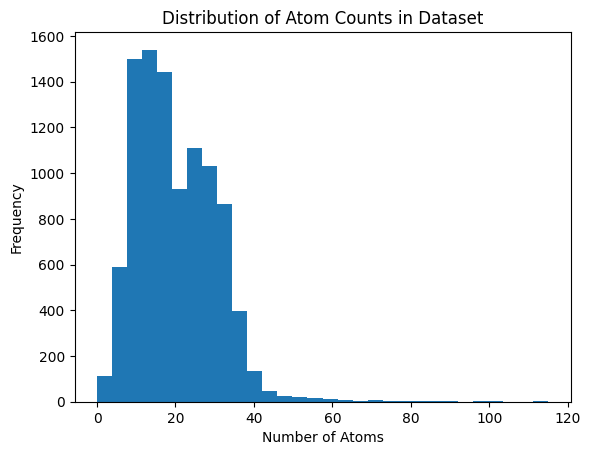

Max atom count: 36


In [3]:
featurizer = QsarGanFeaturizer()
max_atom_count, atom_counts = featurizer.determine_atom_count(smiles=data, quantile=0.95)
visualizer = Visualizer()
visualizer.display_atom_count_distribution(atom_counts)
print(f'Max atom count: {max_atom_count}')
# for simplicity, we set the max atom count to 9 as the default value in BasicMolGAN
featurizer.max_atom_count = 9

# Featurize the data

In [4]:
features = featurizer.get_features(data.copy())

Failed to featurize datapoint 0, F[B-](F)(F)F.[H+]. Appending empty array
Exception message: 5
Failed to featurize datapoint 0, [I-].[K+]. Appending empty array
Exception message: 53
Failed to featurize datapoint 0, C=CC(=O)OCCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, ClCOCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, [Cu]I. Appending empty array
Exception message: 29
Failed to featurize datapoint 0, CO[Si](C)(C)OC. Appending empty array
Exception message: 14
Failed to featurize datapoint 0, BrCBr. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, CCC(Cl)CCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, NC(=S)NNC(N)=S. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, NC(=S)C(N)=S. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, C[Hg]Cl. Appending empty array
Exception message: 80
Failed to featurize

# Train the Gan and generate data

In [5]:
gan = QsarGan(featurizer=featurizer, learning_rate=ExponentialDecay(0.001, 0.9, 5000))
generated_smiles = gan.fit_predict(features=features, epochs=128)

Ending global_step 767: generator average loss -17.6524, discriminator average loss -8.48381
TIMING: model fitting took 74.843 s
Generating 10000 samples


# Extract Descriptors

In [6]:
data_with_descriptors = DescriptorsExtractor.extract_descriptors(generated_smiles)
display(data_with_descriptors)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,SPS
CC1(C)OCC1O,8.850694,8.850694,0.243056,-0.263889,0.471674,37.285714,102.133,92.053,102.068080,42,...,0,0,0,0,0,0,0,0,0,37.285714
CC12COC1CO2,5.192130,5.192130,0.138889,0.138889,0.431859,57.000000,100.117,92.053,100.052429,40,...,0,0,0,0,0,0,0,0,0,57.000000
CCC1OC(C)(C)C1C,5.587963,5.587963,0.153449,0.153449,0.525790,40.000000,128.215,112.087,128.120115,54,...,0,0,0,0,0,0,0,0,0,40.000000
CC1COC12CC2,5.341435,5.341435,0.430556,0.430556,0.441854,43.285714,98.145,88.065,98.073165,40,...,0,0,0,0,0,0,0,0,0,43.285714
COC(C)(C)CO,8.469028,8.469028,0.072917,-0.361111,0.549280,12.000000,104.149,92.053,104.083730,44,...,0,0,0,0,0,0,0,0,0,12.000000
CC1COC1(C)C,5.230324,5.230324,0.180556,0.180556,0.447182,37.285714,100.161,88.065,100.088815,42,...,0,0,0,0,0,0,0,0,0,37.285714
CC1(C)OC2OC21,5.178241,5.178241,0.032407,0.032407,0.413804,52.285714,100.117,92.053,100.052429,40,...,0,0,0,0,0,0,0,0,0,52.285714
CCC1OC(C)(C)C1O,9.310463,9.310463,0.083333,-0.290995,0.571959,40.000000,130.187,116.075,130.099380,54,...,0,0,0,0,0,0,0,0,0,40.000000
CCCC1(C)OCC1O,9.173056,9.173056,0.213542,-0.224583,0.602370,42.333333,130.187,116.075,130.099380,54,...,0,0,0,0,0,0,0,0,0,42.333333
CCC12CC1C(C)(C)O2,5.737269,5.737269,0.218264,0.218264,0.521588,51.666667,126.199,112.087,126.104465,52,...,0,0,0,0,0,0,0,0,0,51.666667


# Display the generated molecules

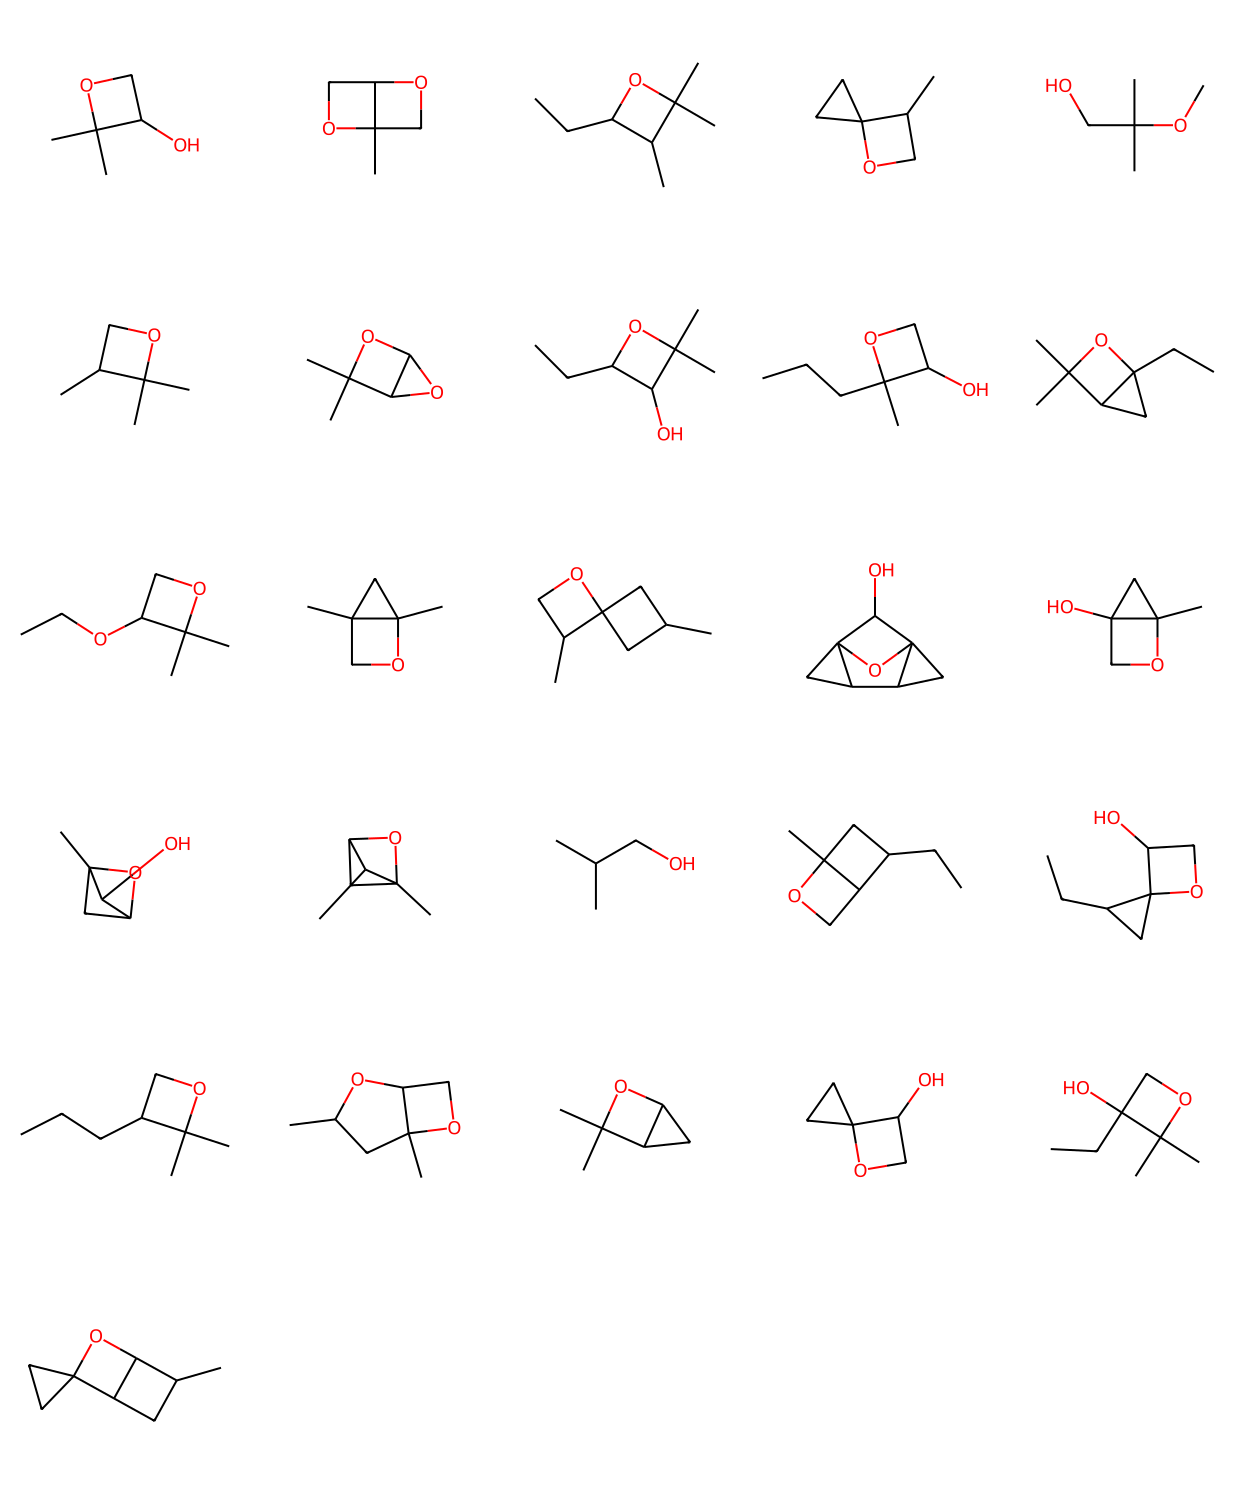

In [7]:
visualizer.draw_generated_molecules(generated_smiles)